<div class="alert alert-success" role="alert">
  <h1 class="alert-heading">Regresión Lineal Multivariado: PLS</h1>
  <h3 class="alert-heading">Prof. Enrique Mejía Ospino, emejia@uis.edu.co</h3>
  <h4 class="alert-heading">Escuela de Química</h4>
  <h5 class="alert-heading">Universidad Industrial de Santander</h5>
  <p>
  </div>

In [1]:
#from sklearn import datasets
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import scipy.io #scipy.io me permite leer datos construidos en matlab
from scipy import stats # importando scipy.stats
from scipy.signal import savgol_filter
import scipy as sio
%matplotlib inline

**<font color=blue> Vamos  atilizar para este ejemplo dos archivos en formato de Matlab que contienen (espectros.mat), el primero, las intensidades de espectros FTICR de 40 muestras crudos fracciones y el segundo (propiedad.mat) el valor medido de una propiedad ccr de las muestras.** 

In [2]:
espectros = pd.read_excel('C://Users/usuario/Documents/Marcela_Data_FTIR/Espectros_ATR-FTIR.xlsx', header = None, skiprows = 1)# 
propiedad = pd.read_excel('C://Users/usuario/Documents/Marcela_Data_FTIR/Prop_Dest.xlsx', header = None, skiprows = 1, usecols="C:F")#

In [3]:
propiedad.head()

,2,3,4,5
0,5.664071,10.098290,9.203348,32.69998
1,5.664071,10.098290,9.203348,32.69998
2,9.662352,8.578967,9.401559,22.48379
3,5.333299,9.867340,7.177670,17.70707
4,6.524363,11.819440,5.365552,45.76004


In [4]:
espectros.shape, propiedad.shape # miramos la forma para ver si concuerdan, en este
# caso 40 muestras y 59692 señales de masas

((47, 7469), (47, 4))

In [5]:
data_prop=propiedad[4]
data_signals=espectros.drop(0, axis=1)
#xftir=np.transpose(xftir)# usamos la transpuesta del archivo si es necesario

**<font color=blue> Se realizará un sencillo pre-procesamiento a los espectros, para este ejemplo, podemos escalar los datos con la función StandardScaler o Normalizar con la función Normalizer.  Escogeremos alguna de las dos y luego hacemos la Regresión lineal.** 

In [6]:
#normalizamos los datos
scaler=StandardScaler()
norma=Normalizer()

scaler.fit(data_signals) # calculo la media para poder hacer la transformacion
x_scaled=scaler.transform(data_signals)# Ahora si, escalo los datos y los normalizo
x_norm = preprocessing.normalize(data_signals, norm='l1')# Normaliza los datos
x_nsd = savgol_filter(x_norm, 17, polyorder=2, deriv=2) # Realiza segunda derivada de los datos

**<font color=green> Ahora realizamos el modelo de regresión lineal utilizando el grupo de entrenamiento y graficamos el resultado en terminos de los datos de calibración.** 

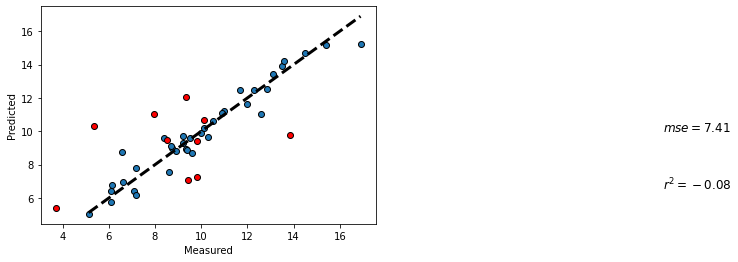

MSE = 7.41


In [7]:
# Separación de los datos en set de entrenamiento y set de prueba
#x_train, x_test, y_train, y_test = train_test_split(x_norm, data_prop, train_size=0.8, random_state=4, shuffle= True)
x_train, x_test, y_train, y_test = train_test_split(data_signals, data_prop, train_size=0.8, random_state=4, shuffle= True)
pls = PLSRegression(n_components=8)
pls.fit(x_train, y_train)

y_pred = pls.predict(x_train)
y_pred_test = pls.predict(x_test)
fig, ax = plt.subplots()
ax.scatter(y_train, y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_test, y_pred_test, color='red', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(30,10, r"$mse = "+str(round(mean_squared_error(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.text(30,6.5, r"$r^2 = "+str(round(r2_score(y_test, y_pred_test), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print('MSE = ' + str(round(mean_squared_error(y_test, y_pred_test), 2)))

In [8]:
def optimise_pls(X, y, xt, n_comp):
    
    # Definimos PLS y el número de componentes
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_pred1 = pls.predict(X)
    y_pred2 = pls.predict(xt)
    # Calculamos métricas
    r2 = r2_score(y, y_pred1)
    mse = mean_squared_error(y, y_pred1)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_pred1, y_pred2, r2, mse, rpd)

In [9]:
# Probamos con 30 componentes
r2s = []
mses = []
rpds = []
yp1 = []
yp2 = []
arr_comp = np.arange(1, 31)
for n_comp in arr_comp:
    y_pred1, y_pred2, r2, mse, rpd = optimise_pls(x_train, y_train, x_test, n_comp)
    r2s.append(r2)
    mses.append(mse)
    rpds.append(rpd)
    yp1.append(y_pred1)
    yp2.append(y_pred2)

C:\Users\usuario\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:323: UserWarning: Y residual constant at iteration 29
  warnings.warn('Y residual constant at iteration %s' % k)


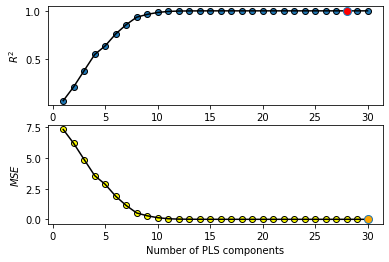

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1)
#fig, ax = plt.subplots()
ax1.scatter(arr_comp, r2s, edgecolors=(0, 0, 0))
ax1.plot(arr_comp, r2s, 'k-')
ax1.plot(arr_comp[np.argmax(r2s)], np.array(r2s)[np.argmax(r2s)], 'o', ms=8, mfc='red')
ax1.set_xlabel('Number of PLS components')
ax1.set_ylabel('$R^2$')

ax2.scatter(arr_comp, mses, color='yellow', edgecolors=(0, 0, 0))
ax2.plot(arr_comp, mses, 'k-')
ax2.plot(arr_comp[np.argmin(mses)], np.array(mses)[np.argmin(mses)], 'o', ms=8, mfc='orange')
ax2.set_xlabel('Number of PLS components')
ax2.set_ylabel('$MSE$')
plt.show()

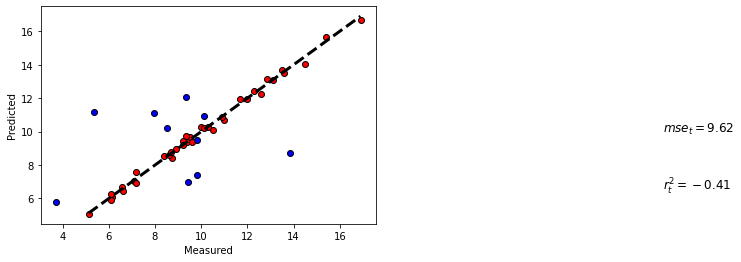

MSE = 0.29


In [11]:
fig, ax = plt.subplots()
ax.scatter(y_train, yp1[10], color='red', edgecolors=(0, 0, 0))
ax.scatter(y_test, yp2[10], color='blue', edgecolors=(0, 0, 0))
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
ax.text(30,10, r"$mse_t = "+str(round(mean_squared_error(y_test, yp2[10]), 2))+r"$", fontsize=12, color="black")
ax.text(30,6.5, r"$r_t^2 = "+str(round(r2_score(y_test, yp2[10]), 2))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print('MSE = ' + str(round(mean_squared_error(y_train, yp1[8]), 2)))

**<font color=black> Seguidamente vamos a realizar un modelo *PLS* utilizando *K-fold* y evaluando cada uno de los modelos originados de las diferentes separaciones através de las métricas $R^2$ y $MSE$.** 

In [12]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
kf = KFold(n_splits=10, shuffle=True, random_state=42) # Vamos hacer 5 separaciones sin barajar en cada separación
model=PLSRegression(n_components=10) # Utilizamos 10 componentes de ajuste del modelo con PLS
x_traint = [] # Creamos arreglos de cada grupo de datos en los que almacenamos las diferentes divisiones 
x_testt = [] # Luego podremos utilizar la mejor separación para obtener el modelo más apropiado
y_traint = []
y_testt = []
r2s = []
mses = []

i = 1
for train_index, test_index in kf.split(x_norm):
    x_train = x_norm[train_index]
    x_test = x_norm[test_index]
    y_train = data_prop[train_index]
    y_test = data_prop[test_index]
    model.fit(x_train, y_train) #Training the model
    mse = mean_squared_error(y_test, model.predict(x_test))
    r2= r2_score(y_test, model.predict(x_test))
    
    # Almacenamos cada grupo en los arreglos creados
    x_traint.append(x_train) 
    x_testt.append(x_test)
    y_traint.append(y_train)
    y_testt.append(y_test)
    r2s.append(r2)
    mses.append(mse)
   
    # Entrenamos el modelo para cada separación the model
    model.fit(x_train, y_train) #Training the model
    print(f"MSE. {i} on the test set: {mean_squared_error(y_test, model.predict(x_test))}")
    print(f"R2. {i} on the test set: {r2_score(y_test, model.predict(x_test))}")
    i += 1

MSE. 1 on the test set: 19.48586267579362
R2. 1 on the test set: -0.5844501918439855
MSE. 2 on the test set: 4.649202443281672
R2. 2 on the test set: 0.5725256675033175
MSE. 3 on the test set: 13.325539492347497
R2. 3 on the test set: -0.35890654848116177
MSE. 4 on the test set: 11.177938323351288
R2. 4 on the test set: -3.490527545376013
MSE. 5 on the test set: 24.37475333756533
R2. 5 on the test set: -3.4751185773755644
MSE. 6 on the test set: 12.286570512695741
R2. 6 on the test set: 0.06880828529618643
MSE. 7 on the test set: 16.10144190010679
R2. 7 on the test set: -4.201046127846957
MSE. 8 on the test set: 11.006344260773918
R2. 8 on the test set: -3.0638216632430364
MSE. 9 on the test set: 2.3628556083179753
R2. 9 on the test set: -34.43042047844651
MSE. 10 on the test set: 7.09928277409737
R2. 10 on the test set: -0.5209794637139369


**<font color=red> Vamos a convertir el mejor set (el de mejor comportamiento) en arreglos númerico y luego seran usados para construir el modelo PLS.** 

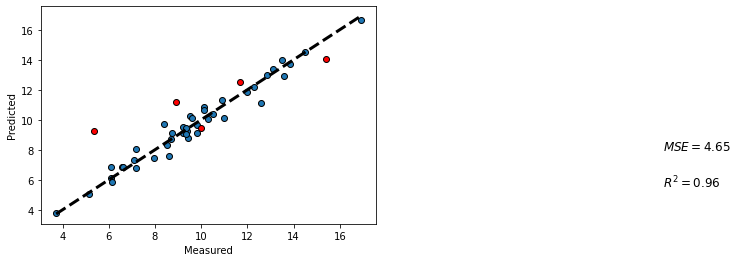

In [13]:
y_tr=np.array(y_traint[r2s.index(max(r2s))]) # Escogemos el mejor set a partir del que presente el
y_te=np.array(y_testt[r2s.index(max(r2s))]) # el valor máximo de r2. Podríamos también elegir el que
X_tr=np.array(x_traint[r2s.index(max(r2s))]) # presente el menor valor del mse
X_te=np.array(x_testt[r2s.index(max(r2s))])
model.fit(X_tr, y_tr) # Ejecutamos el modelo PLS con el set de entranamiento de mejor comportamiento

Y_pred = model.predict(X_tr) # Con el modelo predicmos los valos de la propiedad
Y_pred_test = model.predict(X_te) # Evaluamos las muestras de prueba

fig, ax = plt.subplots()
ax.scatter(y_tr, Y_pred, edgecolors=(0, 0, 0))
ax.scatter(y_te, Y_pred_test, color='red', label='test set', edgecolors=(0, 0, 0))
ax.plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--', lw=3)
ax.text(30,8, r"$MSE = "+str("{0:.2f}".format(mean_squared_error(y_te, Y_pred_test)))+r"$", fontsize=12, color="black")
ax.text(30,5.5, r"$R^2 = "+str("{0:.2f}".format(r2_score(y_tr, Y_pred)))+r"$", fontsize=12, color="black")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [14]:
import pandas as pd 
import numpy as np 
import sklearn
#from google.colab import files, drive, data_table
#from google.colab.data_table import *
from lightgbm import *
from sklearn.ensemble import *
from sklearn.ensemble import *
from sklearn.neural_network import *
from sklearn.model_selection import *
from sklearn.naive_bayes import *
from xgboost import *
from sklearn.svm import *
from sklearn.linear_model import *
from genetic_selection import GeneticSelectionCV
from sklearn.metrics import *

from sklearn.tree import *
import warnings
from sklearn.utils import *
from yellowbrick.model_selection import * 
from yellowbrick.classifier import * 
import matplotlib.pyplot as plt
#from bayes_opt import *
#from mlxtend.feature_selection import *
import warnings
warnings.filterwarnings("ignore")
#import h2o
##from h2o.automl import H2OAutoML
##h2o.init()

mcc = make_scorer(matthews_corrcoef)

In [16]:
#kf = KFold(n_splits=10, shuffle=True, random_state=42) # Vamos hacer 5 separaciones sin barajar en cada separación
estimator=PLSRegression() # Utilizamos 10 componentes de ajuste del modelo con PLS

#estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)

from sklearn.model_selection import *
report = pd.DataFrame()
novar = [] 
chosen_var = [] 
cvscore = [] 
#rkf = RepeatedStratifiedKFold(n_repeats = 20, n_splits = 5)
rkf =  KFold(n_splits=5)#, shuffle=True, random_state=42) # Vamos hacer 5 separaciones sin barajar en cada separación
selector = GeneticSelectionCV(estimator, cv=5)
selector = selector.fit(data_signals, data_prop)
genfeats =data_signals.columns[selector.support_]
genfeats = list(genfeats)
print("Variables seleccionadas:  ", genfeats)
cv_score = selector.generation_scores_[-1]
novar.append(len(genfeats)) 
chosen_var.append(genfeats) 
cvscore.append(cv_score)
report["# de variables"] = novar
report["Variables seleccionadas"] = chosen_var
report["Scores"] = cvscore

Variables seleccionadas:   [17, 26, 34, 46, 72, 92, 97, 110, 115, 122, 127, 136, 137, 152, 167, 173, 183, 200, 236, 299, 348, 382, 470, 493, 507, 510, 513, 540, 593, 609, 627, 633, 658, 677, 717, 720, 760, 763, 786, 824, 827, 830, 834, 842, 843, 854, 860, 866, 873, 886, 915, 941, 966, 973, 988, 1048, 1164, 1168, 1186, 1221, 1240, 1316, 1399, 1423, 1424, 1428, 1429, 1431, 1450, 1455, 1497, 1500, 1581, 1583, 1594, 1603, 1646, 1697, 1763, 1799, 1807, 1865, 1887, 1890, 1915, 1966, 1968, 1990, 2017, 2033, 2046, 2088, 2366, 2432, 2517, 2533, 2562, 2574, 2611, 2620, 2638, 2842, 2870, 2871, 2905, 2920, 2929, 2969, 2974, 2987, 2996, 3012, 3015, 3031, 3063, 3075, 3104, 3113, 3144, 3148, 3159, 3187, 3211, 3236, 3257, 3274, 3304, 3317, 3329, 3363, 3371, 3378, 3386, 3402, 3457, 3473, 3478, 3495, 3508, 3518, 3525, 3548, 3552, 3567, 3668, 3706, 3753, 3754, 3755, 3775, 3786, 3796, 3816, 3820, 3859, 3868, 3898, 3930, 3945, 3950, 3969, 3984, 4014, 4027, 4043, 4071, 4110, 4120, 4145, 4146, 4171, 4204, 42

In [19]:
report["# de variables"]

0    290
Name: # de variables, dtype: int64

In [99]:
data_signals=data_signals.values
data_signals

array([[0.00039159, 0.00040888, 0.00041878, ..., 0.02342516, 0.01912189,
        0.0145559 ],
       [0.01564731, 0.01560988, 0.01556642, ..., 0.01467085, 0.01781906,
        0.02012608],
       [0.01156513, 0.01154839, 0.01151027, ..., 0.00678128, 0.01028299,
        0.0141875 ],
       ...,
       [0.01307893, 0.01308421, 0.01310182, ..., 0.02759306, 0.02708071,
        0.02551889],
       [0.01426656, 0.014296  , 0.01431272, ..., 0.0026291 , 0.00302886,
        0.00396688],
       [0.01218667, 0.01219231, 0.0121875 , ..., 0.02249976, 0.02110288,
        0.01786973]])